# Sieci neuronowe i Deep Learning
# Temat 7: Konwolucyjne sieci neuronowe

Potrzebne pakiety i ich rekomendowane minimalne wersje:
`numpy`: 1.21.2,
`scipy`: 1.7.0,
`matplotlib`: 3.4.3,
`torch`: 1.8.0,
`torchvision`: 0.9.0.

### Jednowymiarowa konwolucja dyskretna

In [1]:
import torch
import numpy as np

In [2]:
# Konwolucja w Python (implementacja wprost i z NumPy):

def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot))) + 1, s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)

In [3]:
# Test/porównanie:

x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d Implementation:',
      conv1d(x, w, p=2, s=1))

print('Numpy Results:',
      np.convolve(x, w, mode='same'))

Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Results: [ 5 14 16 26 24 34 19 22]


### Dwuwymiarowa konwolucja dyskretna

In [4]:
# Implementacja konwolucji 2D
# (podejście wprost oraz z funkcją scipy.signal.convolve2d z pakietu scipy.signal):

import scipy.signal


def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - 
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - 
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

In [5]:
# Przykład i porównanie:
X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))

print('SciPy Results:\n',
    scipy.signal.convolve2d(X, W, mode='same'))

Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


-----------

Architektura sieci:

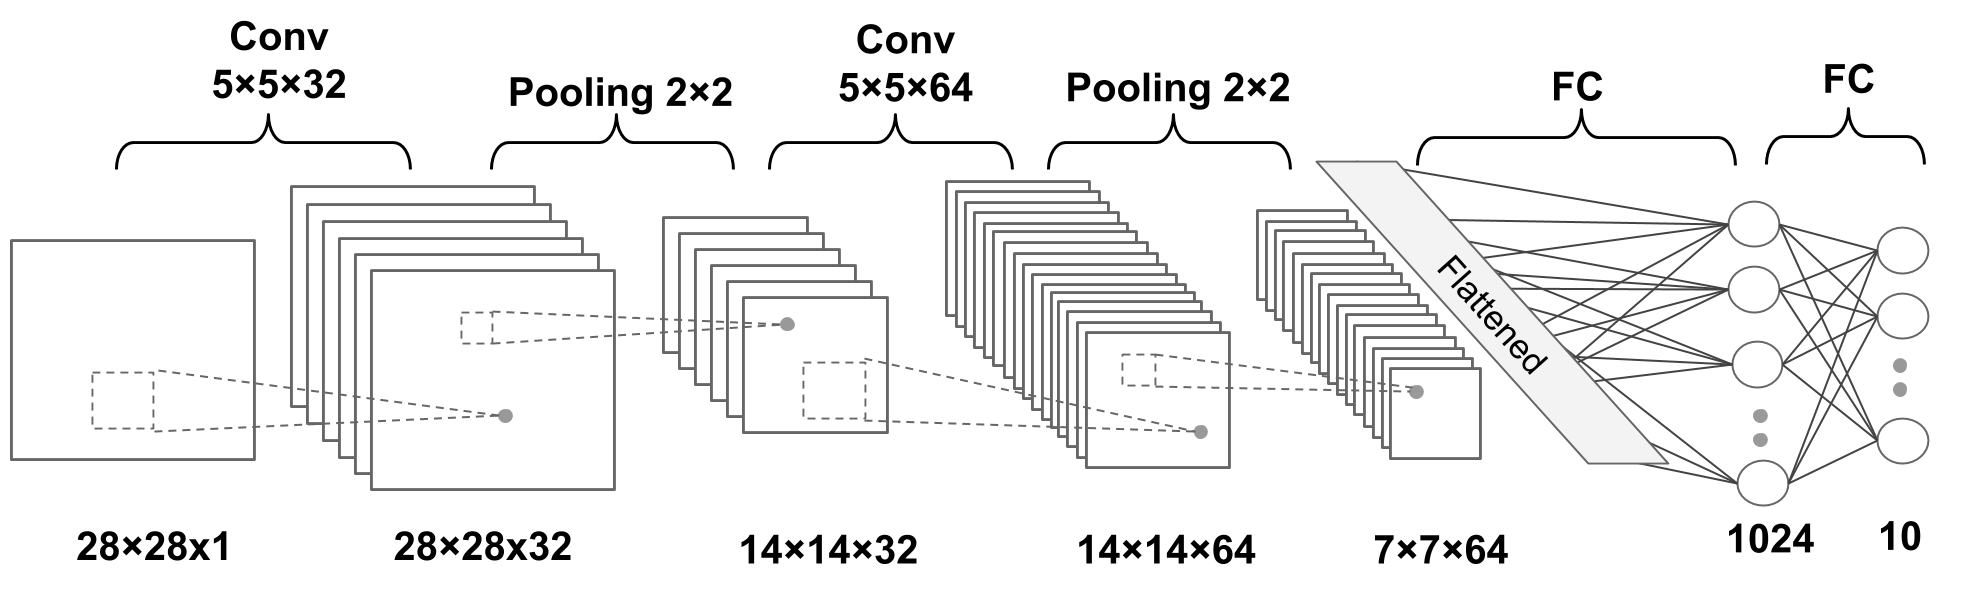

In [19]:
from IPython.display import Image
%matplotlib inline

Image(filename='cnn_mnist.png')

Wczytanie danych MNIST (tak samo jak na wykładzie 3):

In [6]:
import torchvision 
from torchvision import transforms 
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=True)

Tworzymy zbiory: treningowy, walidacyjny, testowy:

In [7]:
import torch

from torch.utils.data import Subset

mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000)) 
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=False, 
                                           transform=transform, 
                                           download=False)

Tworzymy dataloadery dla zbiorów treningowego i walidacyjnego:

In [8]:
from torch.utils.data import DataLoader

batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

#### W module `torch.nn` dostępne są klasy dla standardowych składowych sieci konwolucyjnych:

 * **Conv2d:** `torch.nn.Conv2d`
   * `out_channels` - liczba kanałów wyjściowych (= liczba map cech)
   * `kernel_size`
   * `stride` - domyślnie ustawiony na 1
   * `padding`

`Conv2D` zakłada, że wejście jest w formacie
NCHW (liczba kanałów obrazu jest w pierwszym lub drugim (jeśli uwzględniamy rozmiar wsadu) wymiarze tensora wejściowego);
NChannelsHeightWidth.
   
   
 * **MaxPool2d:** `torch.nn.MaxPool2d`
   * `kernel_size` - rozmiar okna, z którego będzie liczona odpowiednia statystyka
   * `stride` - domyślnie ustawiany na kernel size
   * `padding`
   
   
 * **Dropout** `torch.nn.Dropout`
   * `p` - prawdopodobieństwo wyłączenia neuronu (sygnału wejściowego) podczas uczenia

### Konstrukcja sieci CNN w PyTorch

Używamy klasy `Sequential` z `torch.nn`. Dodajmy warstwy konwolucyjne oraz pooling:

In [9]:
import torch.nn as nn

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

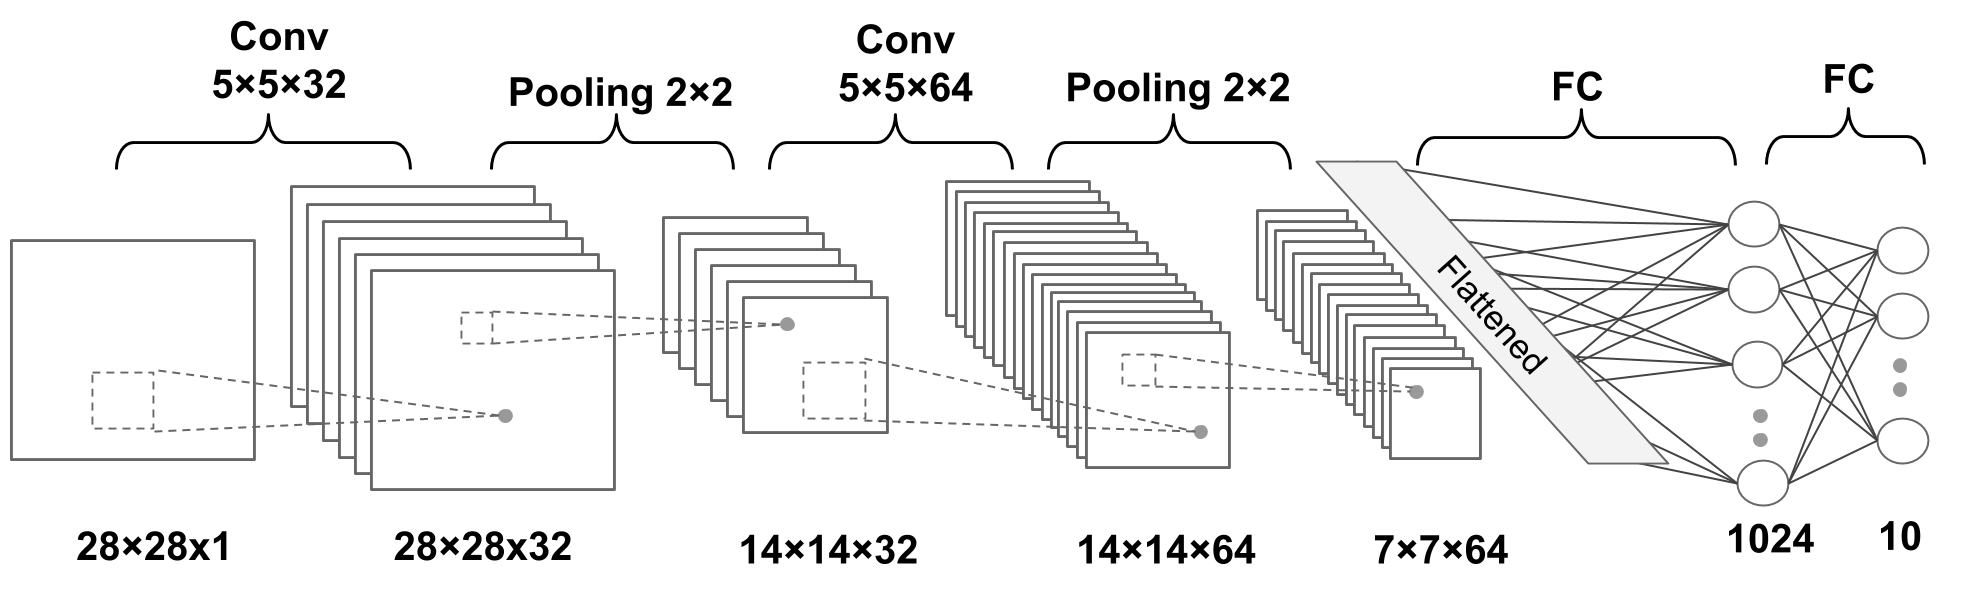

In [21]:
Image(filename='cnn_mnist.png', width = 600)

In [10]:
# Liczenie rozmiaru wyjścia z powyższego modelu:
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

Dane wejściowe do kolejnej warstwy (FC) muszą mieć rząd 2
([batchsize × input_units]). Spłaszczamy wyjście z poprzednich warstw:

In [11]:
model.add_module('flatten', nn.Flatten()) 

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

Dodajmy dwie warstwy typu *fully connected* z warstwą *dropout* pomiędzy:

In [12]:
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))

model.add_module('fc2', nn.Linear(1024, 10))  # 10 dla 10 etykiet

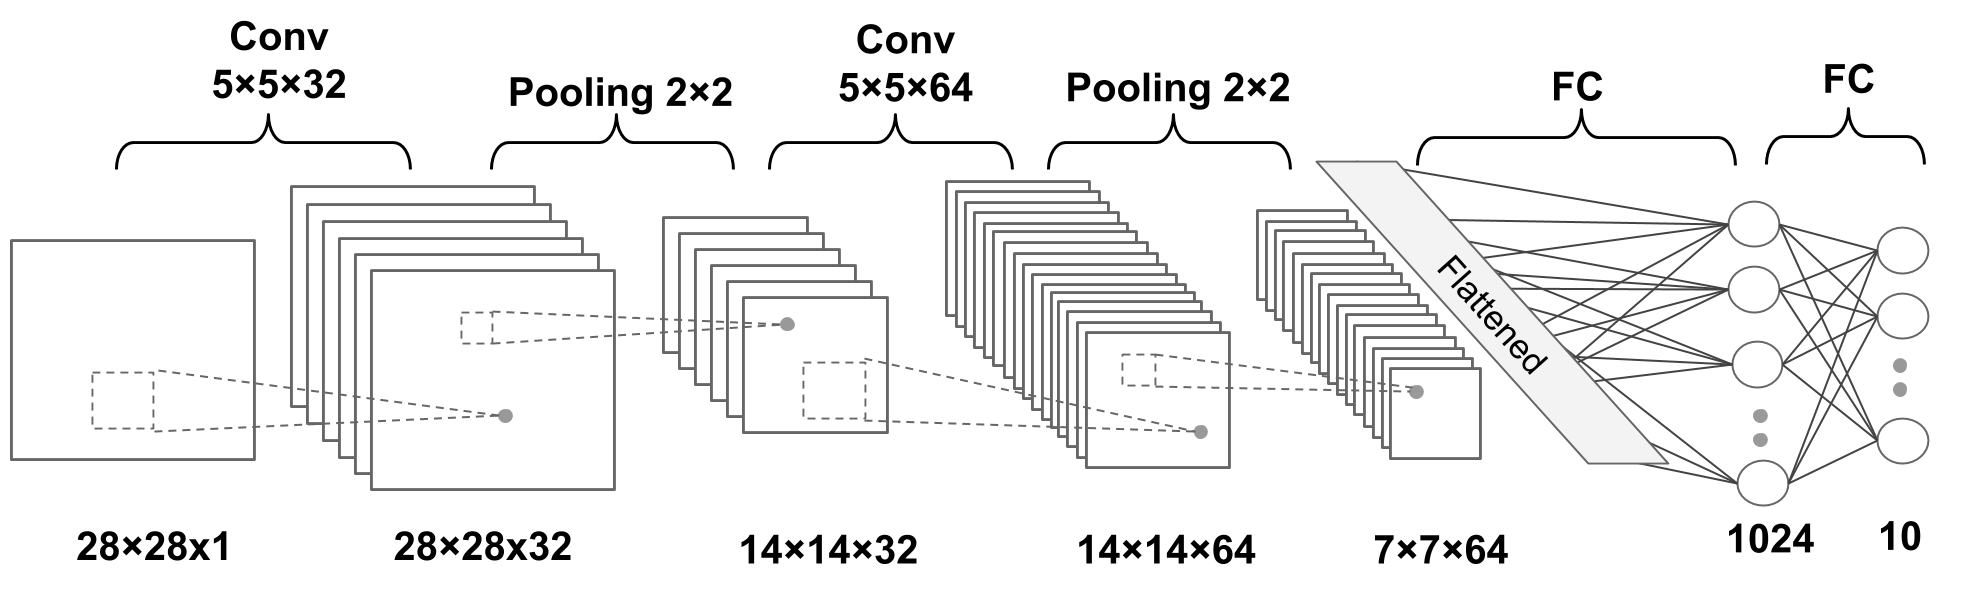

In [22]:
Image(filename='cnn_mnist.png', width = 600)

W implementacji `CrossEntropyLoss` (w PyTorch) domyślnie używana jest funkcja aktywacji softmax, dlatego nie trzeba dodawać jej jawnie jako warstwy wyjściowej powyżej.

In [13]:
# Ustawienie urządzenia (device),
# na którym będzie wykonywany model sieci neuronowej
# i przesłanie tego modelu na wybrane urządzenie:

# device = torch.device("cuda:0")  # na pierwsze dostępne GPU
device = torch.device("cpu")

model = model.to(device) 

Wybieramy funkcję straty oraz optymalizator:

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Definiujemy funkcję train:

In [15]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

Uruchamiamy uczenie:

In [16]:
torch.manual_seed(1)

num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9494 val_accuracy: 0.9815
Epoch 2 accuracy: 0.9842 val_accuracy: 0.9850
Epoch 3 accuracy: 0.9892 val_accuracy: 0.9872
Epoch 4 accuracy: 0.9913 val_accuracy: 0.9878
Epoch 5 accuracy: 0.9930 val_accuracy: 0.9864
Epoch 6 accuracy: 0.9947 val_accuracy: 0.9897
Epoch 7 accuracy: 0.9952 val_accuracy: 0.9879
Epoch 8 accuracy: 0.9957 val_accuracy: 0.9892
Epoch 9 accuracy: 0.9964 val_accuracy: 0.9885
Epoch 10 accuracy: 0.9968 val_accuracy: 0.9900
Epoch 11 accuracy: 0.9969 val_accuracy: 0.9907
Epoch 12 accuracy: 0.9976 val_accuracy: 0.9905
Epoch 13 accuracy: 0.9978 val_accuracy: 0.9904
Epoch 14 accuracy: 0.9976 val_accuracy: 0.9893
Epoch 15 accuracy: 0.9976 val_accuracy: 0.9903
Epoch 16 accuracy: 0.9984 val_accuracy: 0.9895
Epoch 17 accuracy: 0.9979 val_accuracy: 0.9911
Epoch 18 accuracy: 0.9981 val_accuracy: 0.9915
Epoch 19 accuracy: 0.9979 val_accuracy: 0.9913
Epoch 20 accuracy: 0.9982 val_accuracy: 0.9904


Wykresy krzywych uczenia:

In [24]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

ModuleNotFoundError: No module named 'matplotlib.backends.registry'

Sprawdzenie modelu na zbiorze testowym:

In [25]:
# Jeśli liczyliśmy na GPU, to synchronizujemy wszystkie operacje CUDA
# oraz przenosimy model z GPU na CPU:
# torch.cuda.synchronize()
# model_cpu = model.cpu()

pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

Test accuracy: 0.9915


12 przykładów ze zbioru testowego wraz z predykcjami:

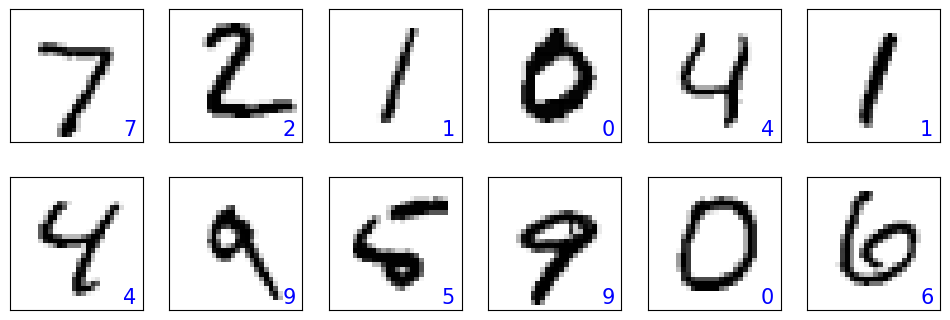

In [26]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)

plt.show()

In [34]:
# Zapisanie modelu do pliku:

import os

if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/mnist-cnn.ph'
torch.save(model, path)